# Cookie Cats A/B Test — Does Moving the Gate Improve Retention?

**Goal** Measure the impact of moving the gate from level 30 → 40 on Day-1 and Day-7 retention.

**Design** Randomized A/B test: `gate_30` (control) vs `gate_40` (treatment).  
**Dataset** One row per player with `version`, `sum_gamerounds`, `retention_1`, `retention_7`.

**Analysis plan**
1) EDA + data cleaning.  
2) Estimate retention rates by version; visualize.  
3) Statistical test: two-proportion z-test for D1 and D7.  
4) Report effect sizes (percentage-point deltas) and CIs; business recommendation.


**Result** Day 1 retention unchanged; Day 7 retention significantly lower.

**Effect** −0.8 percentage-point drop (small magnitude, statistically significant).

**Recommendation:** Keep the gate at level 30 for better long-term engagement.

**Note on populations** ITT (all users) and Per-Protocol (active users) are reported for A/B testing. This notebook focuses on *active users* (played ≥1 round) and uses ITT as a sensitivity check.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import pathlib 
from pathlib import Path
from IPython.display import display

In [2]:
# loading in dataset 
df = pd.read_csv("data/mobile-games-ab-testing.csv")

In [3]:
# EDA below
df.head()
df.info()
df.shape
df.describe().T
df.isnull().sum().sort_values(ascending = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [4]:
# Sanity checking data types but we've seen this above already 
df.dtypes

# This slipped me up above but version is currently stored as an object. I will be changing it to category for memory effiency, performance, and semantics.
df['version'] = df['version'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   userid          90189 non-null  int64   
 1   version         90189 non-null  category
 2   sum_gamerounds  90189 non-null  int64   
 3   retention_1     90189 non-null  bool    
 4   retention_7     90189 non-null  bool    
dtypes: bool(2), category(1), int64(2)
memory usage: 1.6 MB


In [5]:
retention_summary = df.groupby('version', observed = True )[['retention_1', 'retention_7']].mean().reset_index()
retention_summary
# changing the day 1 retention and day 7 retention columns to percentage for ease of readability
retention_summary[['retention_1', 'retention_7']] *= 100
retention_summary

,version,retention_1,retention_7
0,gate_30,44.818792,19.020134
1,gate_40,44.228275,18.200004


As I continue in my EDA phase, I realize that players who have sum_gamerounds equal to zero should be removed. These players installed the game but never actually played a single round in the first 14 days. They're not considered 'active' players in this analysis and never entered the game loop. This is just noise without insight. Therefore I am removing them below.

In [6]:
df = df[df['sum_gamerounds'] > 0] 
df['sum_gamerounds'].describe()
# We now see the min is 1.00 , that's excellent, this means everyone played at least once. 

count    86195.00000
mean        54.27606
std        199.19155
min          1.00000
25%          6.00000
50%         18.00000
75%         54.00000
max      49854.00000
Name: sum_gamerounds, dtype: float64

To further explain, in this A/B testing experiment, I have moved from ITT (Intention-to-Treat) to Per-Protocol population. So instead of the install-to-retain funnel, I am looking at the active users and looking at data that reflects the game's changes and effects on engaged players. This is to ensure the users included in this analysis engaged with the game and were exposed to the experimental condition.

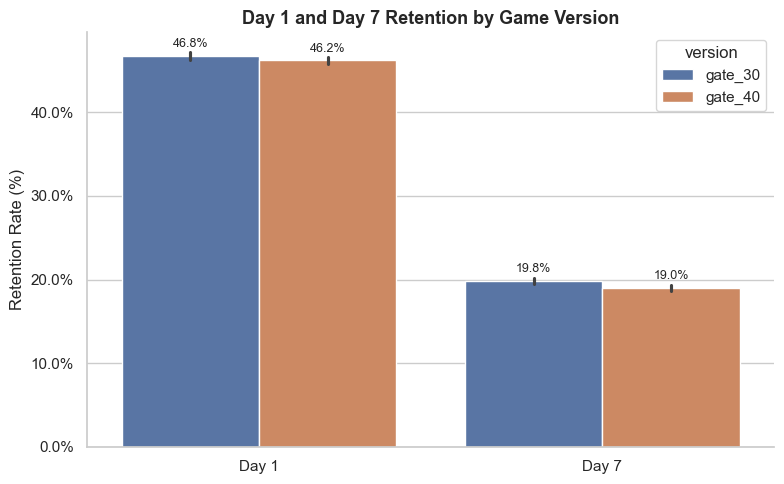

In [15]:
retention_melted = df.melt(
    id_vars='version', 
    value_vars=['retention_1', 'retention_7'], 
    var_name='day', 
    value_name='retained'
)
retention_melted['day'] = retention_melted['day'].str.replace('retention_', 'Day ')
retention_melted.head() 

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8,5))

# Plot means with 95% CIs
ax = sns.barplot(
    data=retention_melted,
    x='day', y='retained', hue='version',
    estimator=np.mean,
    errorbar=('ci', 95)
)

# Percent axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Nice spine and layout
sns.despine()
plt.title("Day 1 and Day 7 Retention by Game Version", fontsize=13, weight='bold')
plt.ylabel("Retention Rate (%)")
plt.xlabel("")
plt.tight_layout()

# Add percent labels on the bars
for container in ax.containers:
    heights = [b.get_height()*100 for b in container]
    ax.bar_label(container, labels=[f"{h:.1f}%" for h in heights],
                 label_type='edge', padding=4 , fontsize=9)

plt.show()

So we’ve just visualized retention differences between the two experimental versions (gate_30 vs gate_40), but we need to know whether those differences are statistically significant or could have occurred by chance. Since retention_1 and retention_7 are binary ( 1 = retained, 0 = not retained), a two-proportion z-test is the correct statistical test to compare retention rates between groups. We test the null hypothesis H0 as retention rate for gate_30 = retention rate for gate_40. In other words, there is no difference. Alternative hypothesis is these retention rates are not equal. If the resulting p-value is less than 0.05, the difference is statistically significant.

In [8]:
from statsmodels.stats.proportion import proportions_ztest

for col in ['retention_1', 'retention_7']:
    successes = df.groupby('version', observed = True)[col].sum()
    total = df.groupby('version', observed = True)[col].count()
    stat, pval = proportions_ztest(successes, total)
    print(f"{col}: z={stat:.3f}, p={pval:.4g}") 

retention_1: z=1.577, p=0.1147
retention_7: z=3.013, p=0.002587


### Statistical Significance (Two-Proportion Z-Test)

Here I compare binary retention rates between `gate_30` and `gate_40` using a two-proportion z-test.

- **H₀:** Retention rate (`gate_30`) = Retention rate (`gate_40`)  
- **H₁:** Retention rates differ

I report z-statistic, p-value, and 95% CIs (Wilson) per group, plus the **percentage-point delta** and a CI for the difference. A result is considered statistically significant at α = 0.05.


In [9]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
try:
    from statsmodels.stats.proportion import confint_proportions_2indep
    HAS_DIFF_CI = True
except Exception:
    HAS_DIFF_CI = False

def render_retention_summary(df):
    df_active = df[df['sum_gamerounds'] > 0].copy()

    def group_stats(col):
        g = df_active.groupby('version', observed=True)[col]
        successes = g.sum().astype(int)
        totals    = g.count().astype(int)
        rates     = successes / totals

        s = successes.reindex(['gate_30','gate_40'])
        t = totals.reindex(['gate_30','gate_40'])
        z, p = proportions_ztest(s, t)

        ci_30 = proportion_confint(s['gate_30'], t['gate_30'], method='wilson')
        ci_40 = proportion_confint(s['gate_40'], t['gate_40'], method='wilson')

        diff = rates['gate_40'] - rates['gate_30']
        if HAS_DIFF_CI:
            lo, hi = confint_proportions_2indep(
                s['gate_40'], t['gate_40'],
                s['gate_30'], t['gate_30'],
                method='wald'
            )
        else:
            lo, hi = (np.nan, np.nan)

        return pd.Series({
            'gate_30 rate': rates['gate_30']*100,
            'gate_40 rate': rates['gate_40']*100,
            'diff (pp)':   diff*100,
            'z': z, 'p': p,
            'gate_30 CI low':  ci_30[0]*100, 'gate_30 CI high': ci_30[1]*100,
            'gate_40 CI low':  ci_40[0]*100, 'gate_40 CI high': ci_40[1]*100,
            'diff CI low': lo*100, 'diff CI high': hi*100
        })

    summary = pd.concat(
        [group_stats('retention_1'), group_stats('retention_7')], axis=1
    ).T
    summary.index = ['retention_1','retention_7']

    styled = (summary.round(2)
              .style.format({
                  'gate_30 rate':'{:.2f}%', 'gate_40 rate':'{:.2f}%',
                  'diff (pp)':'{:+.2f}', 'z':'{:.3f}', 'p':'{:.4f}',
                  'gate_30 CI low':'{:.2f}', 'gate_30 CI high':'{:.2f}',
                  'gate_40 CI low':'{:.2f}', 'gate_40 CI high':'{:.2f}',
                  'diff CI low':'{:+.2f}', 'diff CI high':'{:+.2f}',
              }).hide(axis='index'))
    display(styled)
    return summary  # raw numbers if you want to save/export

summary = render_retention_summary(df)

gate_30 rate,gate_40 rate,diff (pp),z,p,gate_30 CI low,gate_30 CI high,gate_40 CI low,gate_40 CI high,diff CI low,diff CI high
46.75%,46.22%,-0.54,1.580,0.1100,46.28,47.23,45.75,46.69,-1.20,+0.13
19.84%,19.03%,-0.81,3.010,0.0000,19.47,20.22,18.67,19.40,-1.34,-0.28


In [10]:
p1, p2 = 0.1984, 0.1903  # convert percentages to proportions
h = 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))
abs(h)

np.float64(0.020471077330752485)

In [11]:
import pathlib, matplotlib.pyplot as plt
pathlib.Path("analysis/figures").mkdir(parents=True, exist_ok=True)
plt.savefig("analysis/figures/retention_by_version.png", dpi=200, bbox_inches="tight")

summary.to_csv("analysis/retention_summary.csv", index=True)

<Figure size 640x480 with 0 Axes>

### Effect Size & Interpretation

The absolute difference in Day-7 retention (Δ = −0.81 pp) represents the **effect size** of the experiment.  
While statistically significant (p ≈ 0.0026), the standardized Cohen’s h ≈ 0.02 indicates a **very small** practical impact.  
Thus, moving the gate from level 30 → 40 slightly reduced long-term retention without producing a meaningful user-experience gain.

## Results & Recommendation

- **D1 retention:** difference not statistically significant (p ≈ 0.115).  
- **D7 retention:** **significant decrease** when moving the gate to level 40 (p ≈ 0.0026).  
- Effect size: ΔD7 ≈ -0.81 percentage points (gate_40 − gate_30).  
- **Business Takeaway:** Although the statistical difference in Day 7 retention is small (−0.8 pp),
even small drops at scale can translate into meaningful revenue loss for live-service games. Keep the gate at **level 30**. Despite appearing player-friendly, delaying the gate likely removed an early commitment point that helps medium-term engagement. 

**Notes.** I exclude users with `sum_gamerounds == 0` (no activation). ITT analysis (all users) is available as a sensitivity check and yields the same directional conclusion.
